A Simple Generative Adversarial Network with Keras

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers import ELU, PReLU, LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers


In [3]:
# Let Keras know that we are using tensorflow as our backend engine
os.environ["KERAS_BACKEND"] = "tensorflow"

# To make sure that we can reproduce the experiment and get the same results
np.random.seed(10)

# The dimension of our random noise vector.
random_dim = 100


In [4]:
def load_minst_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # normalize our inputs to be in the range[-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)


In [5]:
# You will use the Adam optimizer
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator


In [8]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan


In [9]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)


--------------- Epoch 1 ---------------
4/4 [==============================] - 0s 6ms/step


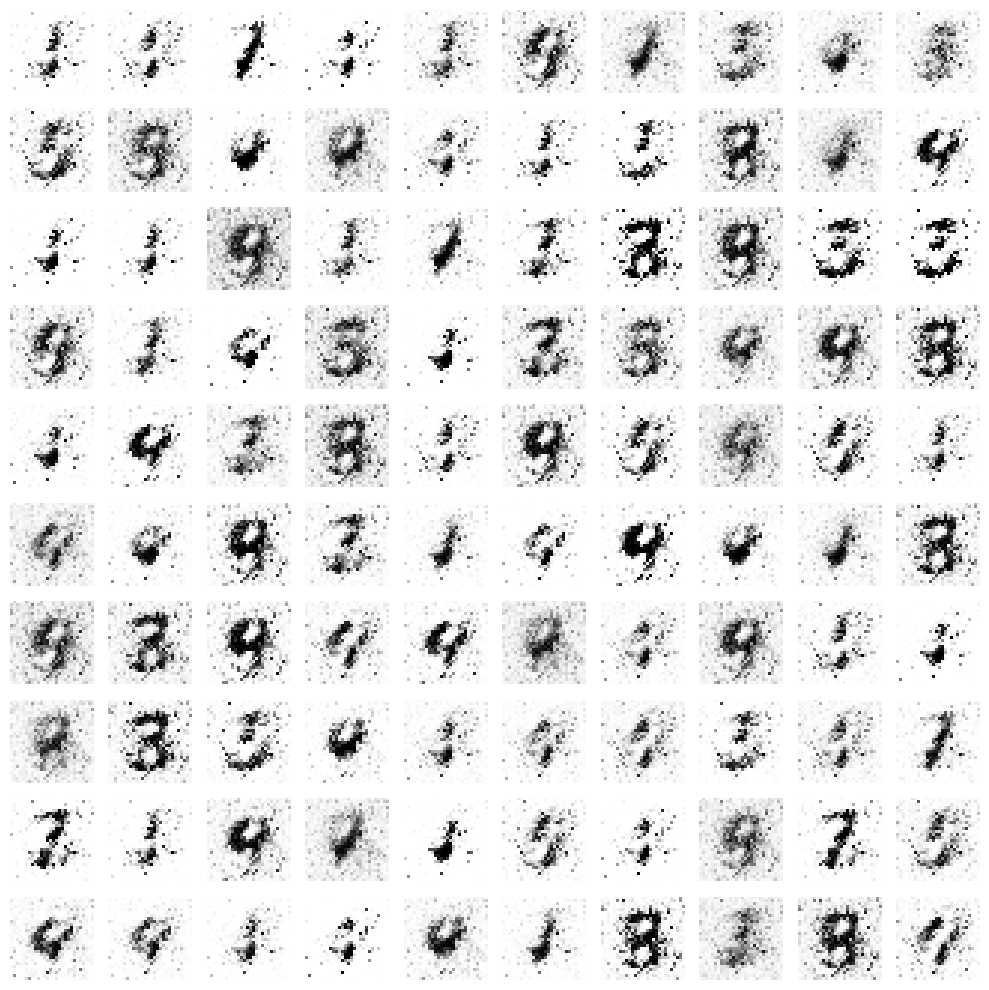

In [19]:
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] // batch_size

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for i in range(batch_count):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

if __name__ == '__main__':
    train(1, 128)
